# Multi-Agent Supervisor

- Author: [Sungchul Kim](https://github.com/rlatjcj)
- Peer Review:
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/17-LangGraph/03-Use-Cases/07-LangGraph-Multi-Agent-Supervisor.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/17-LangGraph/03-Use-Cases/07-LangGraph-Multi-Agent-Supervisor.ipynb)

## Overview

In the previous tutorial, we showed how to automatically route messages based on the output of the initial Researcher agent.
However, when there are multiple agents that need to be coordinated, simple branching logic has limitations.
Here, we introduce how to manage agents through [LLM-based Supervisor](https://langchain-ai.github.io/langgraph/concepts/multi_agent/#supervisor) and coordinate the entire team based on the results of each agent node.


In this tutorial, we'll explore how to build **a multi-agent system** using **LangGraph**, efficiently coordinate tasks between agents, and manage them through **a Supervisor**.  
We'll cover handling multiple agents simultaneously, managing each agent to perform their role, and properly handling task completion.

**Key Points**:
- The Supervisor brings together various expert agents and operates them as a single team.
- The Supervisor agent monitors the team's progress and executes logic such as calling appropriate agents for each step or terminating tasks.

![](./assets/07-langgraph-multi-agent-supervisor.png)

**What We'll Cover in This Tutorial**

- **Setup**: How to install required packages and set up API keys
- **Tool Creation**: Defining tools for agents to use, such as web search and plot generation
- **Helper Utilities**: Defining utility functions needed for creating agent nodes
- **Creating the Supervisor**: Creating a Supervisor that contains logic for selecting Worker nodes and handling task completion
- **Constructing the Graph**: Constructing the complete graph by defining State and Worker nodes
- **Invoking the Team**: Calling the graph to see how the multi-agent system actually works

In this process, we'll use LangGraph's pre-built [create_react_agent](https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.chat_agent_executor.create_react_agent) function to simplify each agent node.

This use of "advanced agents" is meant to demonstrate specific design patterns in LangGraph, and can be combined with other basic patterns as needed to achieve optimal results.

### Table of Contents

- [Overview](#overview)
- [Environment Setup](#environment-setup)
- [Setting State](#setting-state)
- [Creating Agents](#creating-agents)
- [Constructing the Graph](#constructing-the-graph)
- [Calling the Team](#calling-the-team)

### References

- [LangGraph - Multi-Agent - Supervisor](https://langchain-ai.github.io/langgraph/concepts/multi_agent/#supervisor)

## Environment Setup

Set up the environment. You may refer to [Environment Setup](https://wikidocs.net/257836) for more details.

**[Note]**
- `langchain-opentutorial` is a package that provides a set of easy-to-use environment setup, useful functions and utilities for tutorials. 
- You can checkout the [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

In [1]:
%%capture --no-stderr
%pip install langchain-opentutorial

In [30]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "python-dotenv",
        "langchain_core",
        "langchain_community",
        "langchain_openai",
        "langchain_experimental",
        "langgraph",
        "matplotlib",
    ],
    verbose=False,
    upgrade=False,
)

In [6]:
# Set environment variables
from langchain_opentutorial import set_env

set_env(
    {
        "OPENAI_API_KEY": "",
        "LANGCHAIN_API_KEY": "",
        "LANGCHAIN_TRACING_V2": "true",
        "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
        "LANGCHAIN_PROJECT": "Multi-Agent-Supervisor",
    }
)

Environment variables have been set successfully.


You can alternatively set API keys such as `OPENAI_API_KEY` in a `.env` file and load them.

[Note] This is not necessary if you've already set the required API keys in previous steps.

In [7]:
# Load API keys from .env file
from dotenv import load_dotenv

load_dotenv(override=True)

True

## Setting State

Define **state** to be used in the multi-agent system.

In [10]:
import operator
from typing import Annotated, Sequence

from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict


class AgentState(TypedDict):
    """Define state to be used in the multi-agent system."""
    messages: Annotated[Sequence[BaseMessage], operator.add]  # messages
    next: str  # next agent to route to

## Creating Agents

### Creating Tools

In this example, we'll create agents that use a search engine to perform web research and generate plots.

Define the tools to be used below.

- **Research**: Use `TavilySearch` tool to perform web research. To use this tool, you need to set the `TAVILY_API_KEY`. Please refer to [previous tutorial](https://langchain-opentutorial.gitbook.io/langchain-opentutorial/15-agent/01-tools#search-api-tooltavily) for more details.
- **Coder**: Use `PythonREPLTool` tool to run code.

In [16]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.tools import PythonREPLTool


# Initialize Tavily search tool that returns up to 5 search results
tavily_tool = TavilySearchResults(max_results=5)

# Initialize Python REPL tool that runs code locally (may not be safe)
python_repl_tool = PythonREPLTool()

### Creating Utility for Creating Agents

When building a multi-agent system using LangGraph, **helper functions** play a crucial role in creating and managing agent nodes. These functions enhance code reusability and simplify interactions between agents.

- **Creating Agent Nodes**: Define functions to create nodes for each agent's role
- **Managing Workflow**: Provide utilities to manage the workflow between agents
- **Error Handling**: Include mechanisms to handle errors that may occur during agent execution

The following is an example of defining a function called `agent_node`.

This function creates an agent node using the given state and agent. We will call this function later using `functools.partial`.

In [17]:
from langchain_core.messages import HumanMessage


# Create an agent node using the specified agent and name
def agent_node(state, agent, name):
    # Call the agent
    agent_response = agent.invoke(state)
    # Convert the last message of the agent to a HumanMessage and return it
    return {
        "messages": [
            HumanMessage(content=agent_response["messages"][-1].content, name=name)
        ]
    }

Below is an example of creating a `research_node` using `functools.partial`.

In [22]:
import functools

from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent


# Create a Research Agent
research_agent = create_react_agent(ChatOpenAI(model="gpt-4o"), tools=[tavily_tool])

# Create a Research Node
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")


> **Note**
>
> Role of `functools.partial`
>
> `functools.partial` is used to create a new function by fixing some arguments or keyword arguments of an existing function. In other words, it helps simplify commonly used function call patterns.
>
> **Roles**
>
> 1. **Create new function with predefined values**: Returns a new function with some arguments of the existing function pre-specified.
> 2. **Code simplification**: Reduces code duplication by simplifying commonly used function call patterns.
> 3. **Improved readability**: Customizes function behavior for specific tasks to make it more intuitive to use.
>
> **Example code**
> ```python
> research_node = functools.partial(agent_node, agent=research_agent, names="Researcher")
> ```
>
> 1. Assume there is an existing function called `agent_node`.
>    - This function can accept multiple arguments and keyword arguments.
>
> 2. `functools.partial` fixes the values `agent=research_agent` and `names="Researcher"` for this function.
>    - This means that `research_node` no longer needs to specify the `agent` and `names` values when calling `agent_node`.
>    - For example:
>     ```python
>     agent_node(state, agent=research_agent, names="Researcher")
>     ```
>     Instead, you can use:
>     ```python
>     research_node(state)
>     ```

Let's run the code and check the results.

In [23]:
research_node(
    {
        "messages": [
            HumanMessage(content="Code hello world and print it to the terminal")
        ]
    }
)

{'messages': [HumanMessage(content='Here\'s a simple "Hello, World!" program in several different programming languages. You can use any of these to print "Hello, World!" to the terminal:\n\n### Python\n```python\nprint("Hello, World!")\n```\n\n### JavaScript (Node.js)\n```javascript\nconsole.log("Hello, World!");\n```\n\n### Java\n```java\npublic class HelloWorld {\n    public static void main(String[] args) {\n        System.out.println("Hello, World!");\n    }\n}\n```\n\n### C\n```c\n#include <stdio.h>\n\nint main() {\n    printf("Hello, World!\\n");\n    return 0;\n}\n```\n\n### C++\n```cpp\n#include <iostream>\n\nint main() {\n    std::cout << "Hello, World!" << std::endl;\n    return 0;\n}\n```\n\n### Go\n```go\npackage main\n\nimport "fmt"\n\nfunc main() {\n    fmt.Println("Hello, World!")\n}\n```\n\n### Ruby\n```ruby\nputs \'Hello, World!\'\n```\n\n### Bash\n```bash\necho "Hello, World!"\n```\n\nTo run any of these, save the code to a file with the appropriate extension (e.g., 

### Creating Agent Supervisor

Create an agent that manages and supervises agents.

In [24]:
from typing import Literal

from pydantic import BaseModel


# Define the list of member agents
members = ["Researcher", "Coder"]

# Define the list of options for selecting the next worker
options_for_next = ["FINISH"] + members

# Define the response model for selecting the next worker: indicates selecting the next worker or completing the task
class RouteResponse(BaseModel):
    next: Literal[*options_for_next]

In [25]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI


# Define the system prompt: a supervisor tasked with managing a conversation between workers
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)

# Create ChatPromptTemplate
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next? "
            "Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options_for_next), members=", ".join(members))

# Initialize LLM
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Create Supervisor Agent
def supervisor_agent(state):
    # Combine prompt and LLM to create a chain
    supervisor_chain = prompt | llm.with_structured_output(RouteResponse)
    # Call the agent
    return supervisor_chain.invoke(state)

## Constructing the Graph

Now, we're ready to build the graph. Below, we'll use the functions we just defined to define `state` and `worker` nodes.

In [26]:
import functools

from langgraph.prebuilt import create_react_agent


# Create Research Agent
research_agent = create_react_agent(llm, tools=[tavily_tool])
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

code_system_prompt = """
Be sure to use the following font in your code for visualization.

##### Font Setting #####
import platform

# Determine OS
current_os = platform.system()

if current_os == "Windows":
    # Windows environment font setting
    font_path = "C:/Windows/Fonts/malgun.ttf"  # Malgun font path
    fontprop = fm.FontProperties(fname=font_path, size=12)
    plt.rc("font", family=fontprop.get_name())
elif current_os == "Darwin":  # macOS
    # Mac environment font setting
    plt.rcParams["font.family"] = "AppleGothic"
else:  # Other OSs including Linux
    # Try to set the default Korean font
    try:
        plt.rcParams["font.family"] = "NanumGothic"
    except:
        print("Cannot find Korean font. Using system default font.")

##### Prevent minus font from being broken #####
plt.rcParams["axes.unicode_minus"] = False
"""

# Create Coder Agent
coder_agent = create_react_agent(
    llm,
    tools=[python_repl_tool],
    state_modifier=code_system_prompt,
)
coder_node = functools.partial(agent_node, agent=coder_agent, name="Coder")

In [27]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph


# Create graph
workflow = StateGraph(AgentState)

# Add nodes to the graph
workflow.add_node("Researcher", research_node)
workflow.add_node("Coder", coder_node)
workflow.add_node("Supervisor", supervisor_agent)


# Add edges from member nodes to the Supervisor node
for member in members:
    workflow.add_edge(member, "Supervisor")

# Add conditional edges
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END


def get_next(state):
    return state["next"]


# Add conditional edges from the Supervisor node
workflow.add_conditional_edges("Supervisor", get_next, conditional_map)

# Add starting point
workflow.add_edge(START, "Supervisor")

# Compile the graph
graph = workflow.compile(checkpointer=MemorySaver())

Visualize the graph.

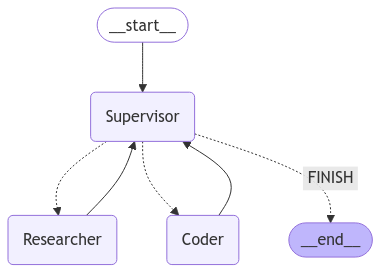

In [28]:
from IPython.display import Image, display
from langgraph.graph.state import CompiledStateGraph


try:
    if isinstance(graph, CompiledStateGraph):
        display(
            Image(
                graph.get_graph().draw_mermaid_png(
                    background_color="white",
                    # node_colors=NodeStyles(),
                )
            )
        )
except Exception as e:
    print(f"[ERROR] Visualize Graph Error: {e}")

## Calling the Team

Now, we can check the performance by calling the graph.


🔄 Node: Supervisor 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: agent in [Researcher] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_bA10FQWyZQmC9LmrOqdDIImY)
 Call ID: call_bA10FQWyZQmC9LmrOqdDIImY
  Args:
    query: South Korea GDP per capita 2010 to 2024

🔄 Node: tools in [Researcher] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://statisticstimes.com/economy/country/south-korea-gdp-per-capita.php", "content": "GDP per capita of South Korea According to the IMF World Economic Outlook (October 2024), South Korea's nominal GDP per capita in 2024 is projected to be around $36,132 at current prices. Based on PPP, South Korea's GDP per capita in 2024 is forecast at 62,960 billion international dollars. 

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

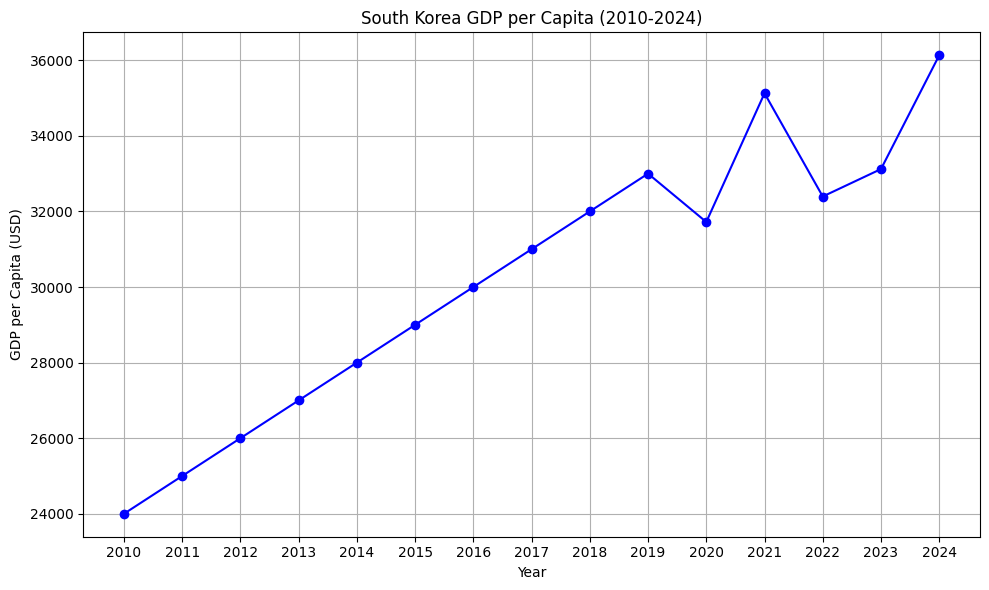


🔄 Node: tools in [Coder] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message =================================
Name: Python_REPL



🔄 Node: agent in [Coder] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

The GDP per capita of South Korea from 2010 to 2024 has been visualized in a line graph. The graph shows a general upward trend, with some fluctuations, particularly around the years impacted by the pandemic. The projected GDP per capita for 2024 indicates a recovery and growth. If you have any further questions or need additional analysis, feel free to ask!

🔄 Node: Coder 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================ Human Message =================================
Name: Coder

The GDP per capita of South Korea from 2010 to 2024 has been visualized in a line graph. The graph shows a general upward trend, with so

In [31]:
import uuid
from typing import Callable

from langchain_core.runnables import RunnableConfig


def invoke_graph(
    graph: CompiledStateGraph,
    inputs: dict,
    config: RunnableConfig,
    node_names: list[str] = [],
    callback: Callable = None,
):
    """
    A function that nicely streams and outputs the execution results of a LangGraph app.

    Args:
        graph (CompiledStateGraph): The compiled LangGraph object to execute
        inputs (dict): Dictionary of input values to pass to the graph
        config (RunnableConfig): Execution configuration
        node_names (list[str], optional): List of node names to output. Defaults to empty list
        callback (Callable, optional): Callback function for processing each chunk. Defaults to None
            The callback function takes a dictionary of the form {"node": str, "content": str} as an argument

    Returns:
        None: The function only outputs streaming results and has no return value
    """

    def format_namespace(namespace):
        return namespace[-1].split(":")[0] if len(namespace) > 0 else "root graph"

    # Include subgraph outputs through subgraphs=True
    for namespace, chunk in graph.stream(
        inputs, config, stream_mode="updates", subgraphs=True
    ):
        for node_name, node_chunk in chunk.items():
            # Filter only if node_names is not empty
            if len(node_names) > 0 and node_name not in node_names:
                continue

            # If callback is provided, execute it
            if callback is not None:
                callback({"node": node_name, "content": node_chunk})
            # If no callback is provided, print the default output
            else:
                print("\n" + "=" * 50)
                formatted_namespace = format_namespace(namespace)
                if formatted_namespace == "root graph":
                    print(f"🔄 Node: \033[1;36m{node_name}\033[0m 🔄")
                else:
                    print(
                        f"🔄 Node: \033[1;36m{node_name}\033[0m in [\033[1;33m{formatted_namespace}\033[0m] 🔄"
                    )
                print("- " * 25)

                # Print the chunk data of the node
                for k, v in node_chunk.items():
                    if isinstance(v, BaseMessage):
                        v.pretty_print()
                    elif isinstance(v, list):
                        for list_item in v:
                            if isinstance(list_item, BaseMessage):
                                list_item.pretty_print()
                            else:
                                print(list_item)
                    elif isinstance(v, dict):
                        for node_chunk_key, node_chunk_value in node_chunk.items():
                            print(f"{node_chunk_key}:\n{node_chunk_value}")
                print("=" * 50)

# Set config (recursion limit, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": str(uuid.uuid4())})

# Set input (question)
inputs = {
    "messages": [
        HumanMessage(
            content="Visualize the GDP per capita of South Korea from 2010 to 2024."
        )
    ],
}

# Run the graph
invoke_graph(graph, inputs, config)